# Matcher OpenVINO Inference Example

This notebook demonstrates how to use the Matcher model with OpenVINO backend for efficient inference on Intel hardware.

## Overview
1. Export a PyTorch Matcher model to OpenVINO format
2. Load the exported model with `InferenceMatcher`
3. Learn from reference samples (few-shot learning)
4. Run inference on target images
5. Compute metrics (Mean IoU)
6. Visualize the results

## Benefits of OpenVINO Backend
- Faster inference on Intel CPUs, GPUs, and NPUs
- Optimized execution with INT8/FP16 precision
- Reduced memory footprint


## Setup and Imports


In [ ]:
import timeit
from pathlib import Path

import matplotlib.pyplot as plt
from torchmetrics.segmentation import MeanIoU

from getiprompt.data.base import Batch
from getiprompt.data.folder import FolderDataset
from getiprompt.models.matcher import InferenceMatcher, Matcher
from getiprompt.utils.benchmark import convert_masks_to_one_hot_tensor
from getiprompt.utils.constants import Backend, SAMModelName

## Configuration

In [2]:
# Configuration parameters
data_root = Path("../tests/assets/fss-1000")
export_dir = Path("./exports/matcher_ov")
output_dir = Path("./output/matcher_ov")

# Model settings
precision = "fp32"  # Options: "fp16", "fp32"
device = "cpu"
sam_model = SAMModelName.SAM_HQ_TINY

# Categories to segment
categories = ["apple"]

# Create output directories
export_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Data root: {data_root}")
print(f"Export directory: {export_dir}")
print(f"Output directory: {output_dir}")
print(f"Device: {device}")
print(f"Precision: {precision}")

Data root: ../tests/assets/fss-1000
Export directory: exports/matcher_ov
Output directory: output/matcher_ov
Device: cpu
Precision: fp32


## Step 1: Load Dataset


In [3]:
# Load the fss-1000 dataset
print("Loading fss-1000 dataset...")
dataset = FolderDataset(
    root=data_root,
    categories=categories,
)

# Get reference and target samples
ref_dataset = dataset.get_reference_dataset()
target_dataset = dataset.get_target_dataset()

print(f"Categories: {dataset.categories}")
print(f"Reference samples: {len(ref_dataset)}")
print(f"Target samples: {len(target_dataset)}")

Loading fss-1000 dataset...
Categories: ['apple']
Reference samples: 1
Target samples: 9


In [4]:
# Create batches
reference_batch = Batch.collate([ref_dataset[i] for i in range(len(ref_dataset))])
target_batch = Batch.collate([target_dataset[i] for i in range(len(target_dataset))])

print(f"Reference batch size: {len(reference_batch.images)}")
print(f"Target batch size: {len(target_batch.images)}")

Reference batch size: 1
Target batch size: 9


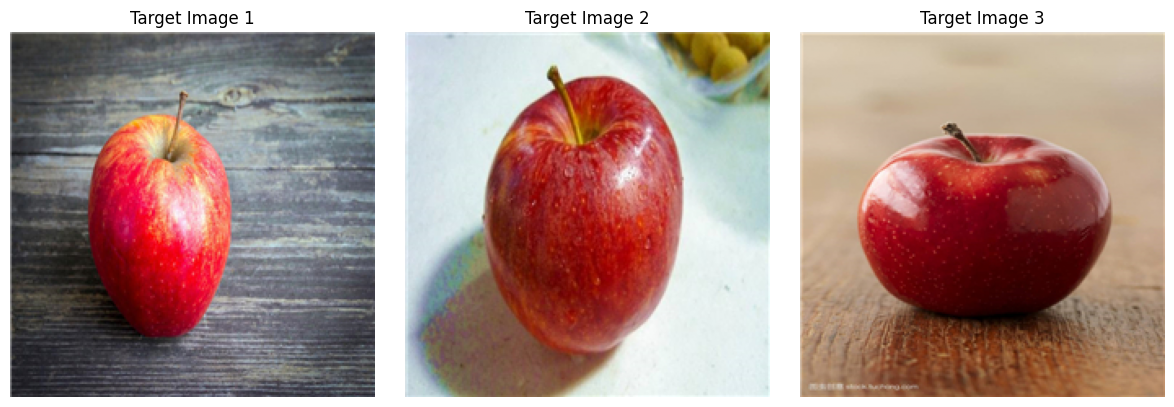

In [5]:
# Display a few example images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    if i < len(target_batch.images):
        img = target_batch.images[i].numpy().transpose(1, 2, 0)
        # Normalize to 0-1 range if needed
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.set_title(f"Target Image {i + 1}")
        ax.axis("off")
plt.tight_layout()
plt.show()

## Step 2: Export Matcher Model to OpenVINO

Before using the `InferenceMatcher`, we need to export the PyTorch Matcher model to OpenVINO format.


In [ ]:
# Check if models are already exported
encoder_path = export_dir / "image_encoder.xml"
sam_path = export_dir / "exported_sam.xml"

# Initialize PyTorch Matcher for export
matcher_pytorch = Matcher(
    sam=sam_model,
    device="cpu",
    precision="fp32",
)

# Export to OpenVINO format
start_time = timeit.default_timer()
matcher_pytorch.export(export_dir=export_dir, backend=Backend.OPENVINO)
export_time = timeit.default_timer() - start_time

print(f"Export completed in {export_time:.2f} seconds")
print("Exported files:")
for f in export_dir.glob("*.xml"):
    print(f"  - {f.name}")

## Step 3: Initialize InferenceMatcher with OpenVINO Backend


In [7]:
# Initialize the OpenVINO-based Matcher
print("Initializing InferenceMatcher with OpenVINO backend...")

start_time = timeit.default_timer()
ov_matcher = InferenceMatcher(
    model_folder=export_dir,
    sam=sam_model,
    mask_similarity_threshold=0.5,
    device=device,
    precision=precision,
)
init_time = timeit.default_timer() - start_time

print(f"InferenceMatcher initialized in {init_time:.2f} seconds")
print(f"Using device: {device}")

Initializing InferenceMatcher with OpenVINO backend...
InferenceMatcher initialized in 1.35 seconds
Using device: cpu


## Step 4: Fit from Reference Samples

In [8]:
# Learn from reference samples (few-shot learning)
print("Fit from reference samples...")

start_time = timeit.default_timer()
ov_matcher.fit(reference_batch)
learn_time = timeit.default_timer() - start_time

print(f"Fitting completed in {learn_time:.2f} seconds")
print(f"Reference embeddings stored for {len(reference_batch.images)} samples")

Fit from reference samples...
Fitting completed in 0.54 seconds
Reference embeddings stored for 1 samples


## Step 5: Run Inference on Target Images


In [9]:
# Run inference on target images
print("Running inference on target images...")

start_time = timeit.default_timer()
predictions = ov_matcher.predict(target_batch)
inference_time = timeit.default_timer() - start_time

print(f"Inference completed in {inference_time:.2f} seconds")
print(f"Processed {len(predictions)} images")
print(f"Average time per image: {inference_time / len(predictions):.4f} seconds")

Running inference on target images...
Inference completed in 22.76 seconds
Processed 9 images
Average time per image: 2.5291 seconds


## Step 6: Compute Metrics (Mean IoU)


In [10]:
# Compute metrics
print("Computing metrics...")

num_classes = len(dataset.categories)
category_id_to_index = {dataset.get_category_id(cat_name): idx for idx, cat_name in enumerate(dataset.categories)}

# Initialize MeanIoU metric
metrics_device = "cpu"
metrics = MeanIoU(
    num_classes=num_classes,
    include_background=True,
    per_class=True,
).to(metrics_device)

# Convert predictions and ground truth to one-hot tensors
batch_pred_tensors, batch_gt_tensors = convert_masks_to_one_hot_tensor(
    predictions=predictions,
    ground_truths=target_batch,
    num_classes=num_classes,
    category_id_to_index=category_id_to_index,
    device=metrics_device,
)

# Update metrics for each image
for pred_tensor, gt_tensor in zip(batch_pred_tensors, batch_gt_tensors, strict=True):
    metrics.update(pred_tensor, gt_tensor)

# Compute final IoU per class
iou_per_class = metrics.compute()

# Print metrics
print("\n" + "=" * 50)
print("METRICS RESULTS")
print("=" * 50)
print(f"  Mean IoU = {iou_per_class:.4f}")
print("=" * 50)

Computing metrics...

METRICS RESULTS
  Mean IoU = 0.9100


## Step 7: Visualize Results


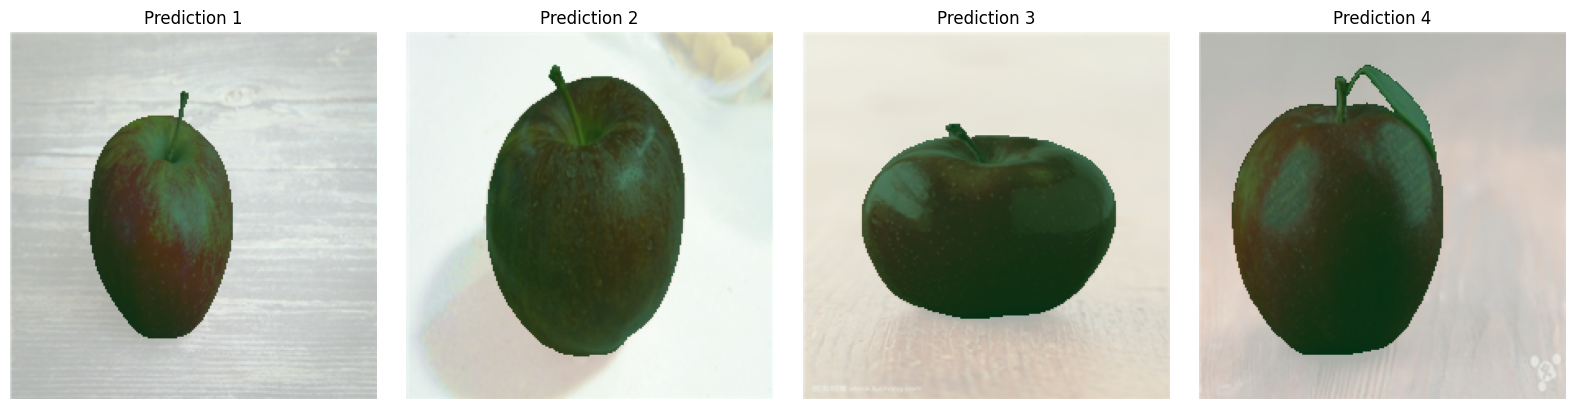

In [20]:
# Display predictions with overlay on original images
num_display = min(4, len(predictions))
fig, axes = plt.subplots(1, num_display, figsize=(4 * num_display, 4))

for i in range(num_display):
    # Original image with mask overlay
    img = target_batch.images[i].numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    axes[i].imshow(img)

    # Overlay prediction mask
    pred_masks = predictions[i]["pred_masks"]
    combined_mask = pred_masks.any(dim=0).cpu().numpy()
    axes[i].imshow(combined_mask, alpha=0.7, cmap="Greens")
    axes[i].set_title(f"Prediction {i + 1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()